**Objective:**
The goal of this project is to predict whether a passenger survived the Titanic disaster using the Titanic dataset from Kaggle. This is a binary classification problem, where the target variable Survived indicates survival (1) or non-survival (0). The task involves data cleaning, exploratory data analysis (EDA), feature engineering, model selection, and hyperparameter tuning to build the most accurate prediction model.

In [37]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (3).csv
Saving train.csv to train (3).csv


In [38]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

**Data Understanding & Preprocessing**

Loaded train and test datasets.

Handled missing values: imputed Age and Embarked, filled missing Fare.

Created new features: FamilySize, IsAlone, Title extracted from names.

Converted categorical variables to numerical using OneHotEncoder.

In [39]:
# load
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_ids = test["PassengerId"]

In [40]:
# combined dataframe for uniform preprocessing
full = pd.concat([train, test], sort=False).reset_index(drop=True)


Train shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


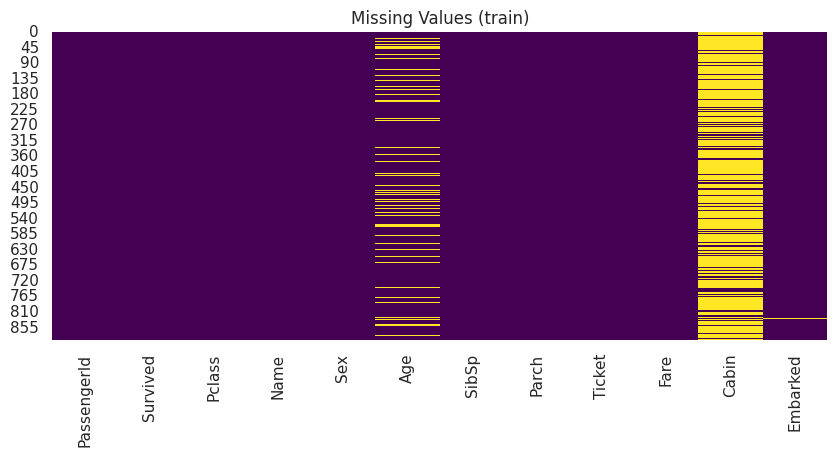

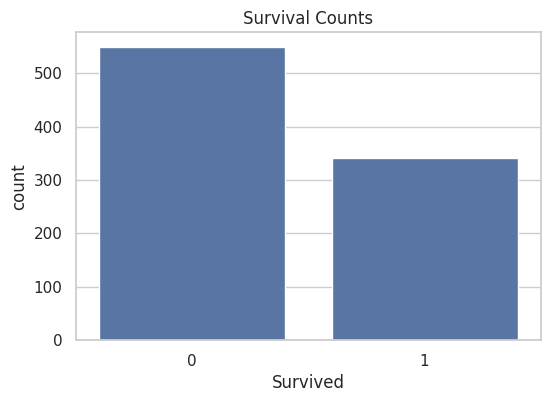

In [41]:
# 1. Quick EDA - overview & missing values

print("Train shape:", train.shape)
display(train.head())

plt.figure(figsize=(10,4))
sns.heatmap(train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values (train)")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x="Survived", data=train)
plt.title("Survival Counts")
plt.show()

**Exploratory Data Analysis (EDA)**

Analyzed survival rates by gender, passenger class, family size, and embarkation port.

Observed key trends:

1. Females had a much higher survival rate than males.

2. First-class passengers survived more often than lower classes.

3. Traveling alone decreased survival chances.

/tmp/ipython-input-1642091669.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="Survived", data=train, ci=None)


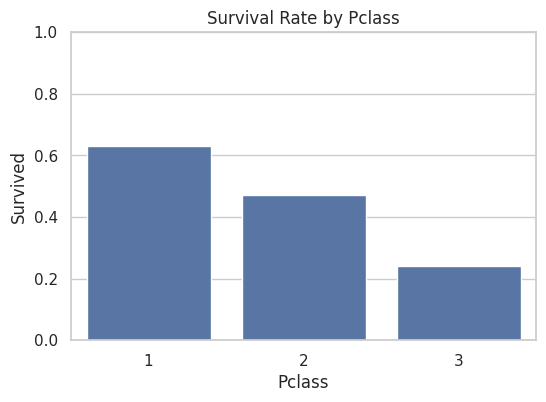

/tmp/ipython-input-1642091669.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="Survived", data=train, ci=None)


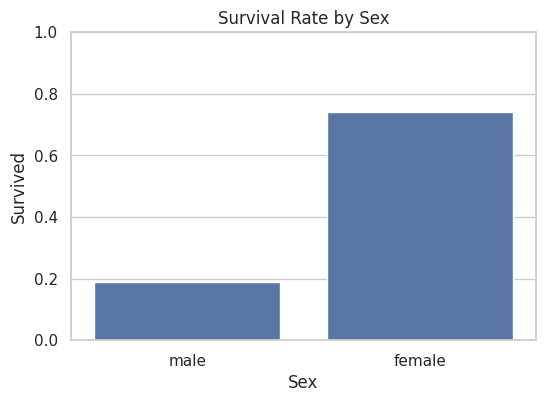

/tmp/ipython-input-1642091669.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="Survived", data=train, ci=None)


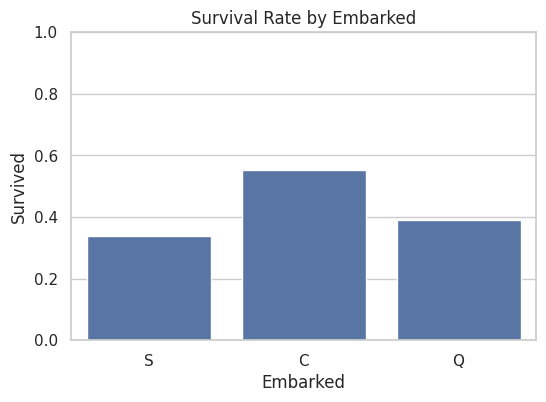

In [43]:
# 2. Automated categorical survival plots

# choose categorical features to visualize
cat_cols = ["Pclass", "Sex", "Embarked"]

# include engineered categories we'll create later (AgeBin, FareBin, Title, IsAlone) if desired
# we will create Title/IsAlone/AgeBin/FareBin below and then re-run this block
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.barplot(x=col, y="Survived", data=train, ci=None)
    plt.title(f"Survival Rate by {col}")
    plt.ylim(0,1)
    plt.show()


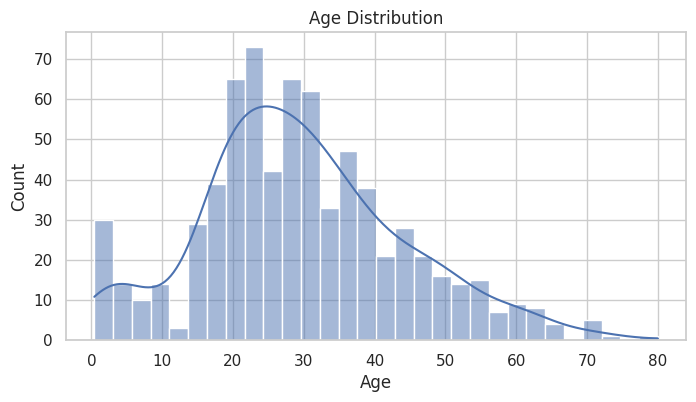

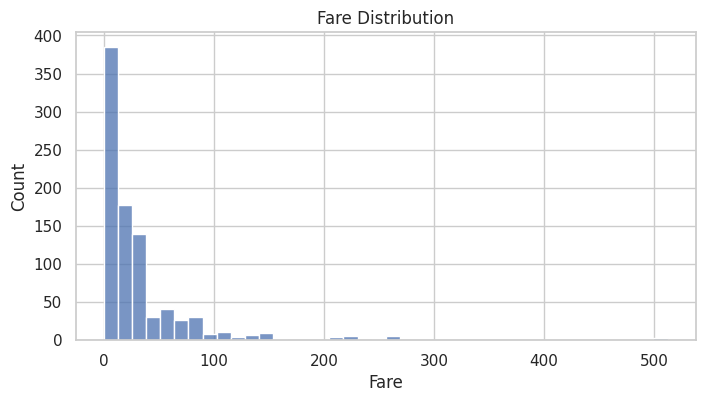

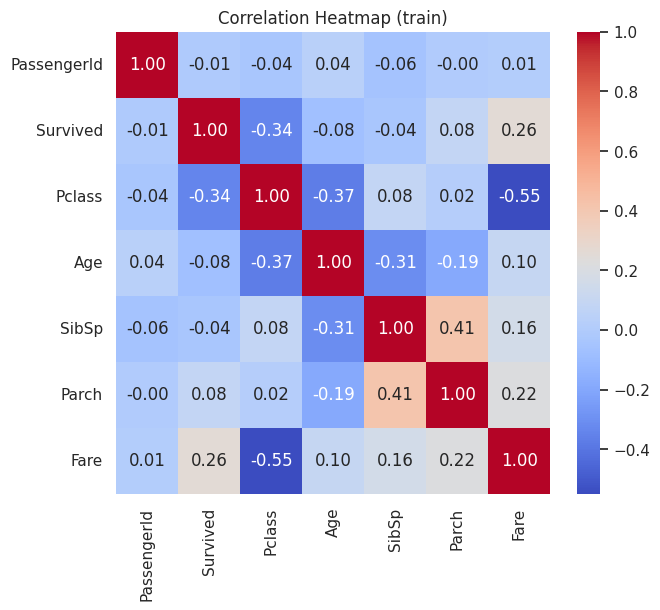

In [44]:
# 3. More numeric EDA

plt.figure(figsize=(8,4))
sns.histplot(train["Age"], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(train["Fare"].fillna(train["Fare"].median()), bins=40)
plt.title("Fare Distribution")
plt.show()

plt.figure(figsize=(7,6))
sns.heatmap(train.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (train)")
plt.show()

In [45]:
# 4. Feature engineering (Title, Family, bins)

full["Title"] = full["Name"].str.extract(" ([A-Za-z]+)\\.", expand=False)
rare_titles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
full["Title"] = full["Title"].replace(rare_titles, "Rare").replace({"Mlle":"Miss","Ms":"Miss","Mme":"Mrs"})

full["FamilySize"] = full["SibSp"] + full["Parch"] + 1
full["IsAlone"] = (full["FamilySize"] == 1).astype(int)

full["Age"].fillna(full["Age"].median(), inplace=True)
full["Fare"].fillna(full["Fare"].median(), inplace=True)
full["Embarked"].fillna(full["Embarked"].mode()[0], inplace=True)

full["AgeBin"] = pd.cut(full["Age"], bins=[0,12,20,40,60,120], labels=["Child","Teen","Adult","Middle","Senior"])
full["FareBin"] = pd.qcut(full["Fare"], 4, labels=["Low","Mid","High","VeryHigh"])

/tmp/ipython-input-3052731758.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full["Age"].fillna(full["Age"].median(), inplace=True)
/tmp/ipython-input-3052731758.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [46]:
# drop unused noisy cols
full.drop(columns=["Name","Ticket","Cabin"], inplace=True)

In [42]:
train_df.isnull().sum()


,0
PassengerId,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0
Title,0


/tmp/ipython-input-3039648631.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="Survived", data=train_view, ci=None)


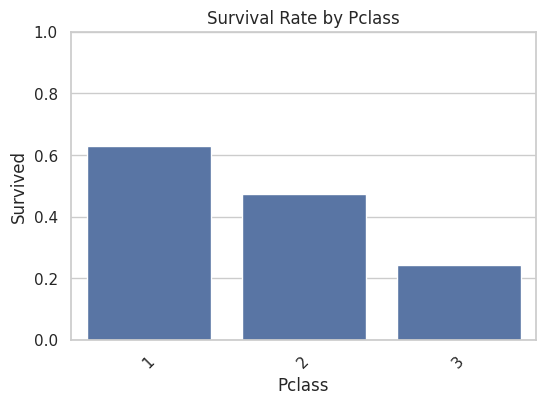

/tmp/ipython-input-3039648631.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="Survived", data=train_view, ci=None)


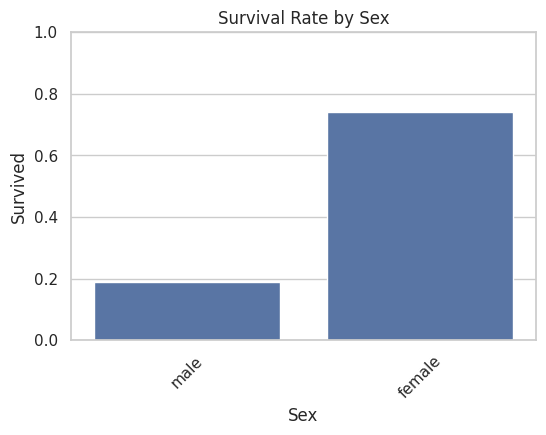

/tmp/ipython-input-3039648631.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="Survived", data=train_view, ci=None)


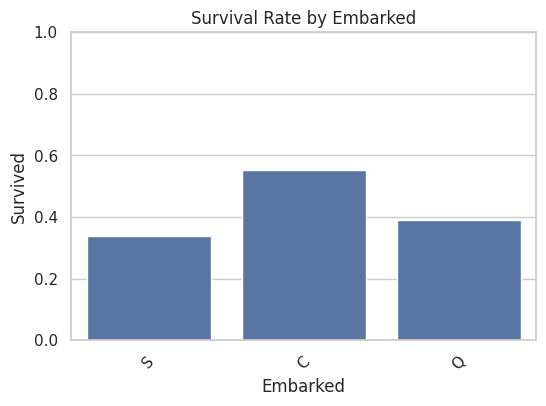

/tmp/ipython-input-3039648631.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="Survived", data=train_view, ci=None)


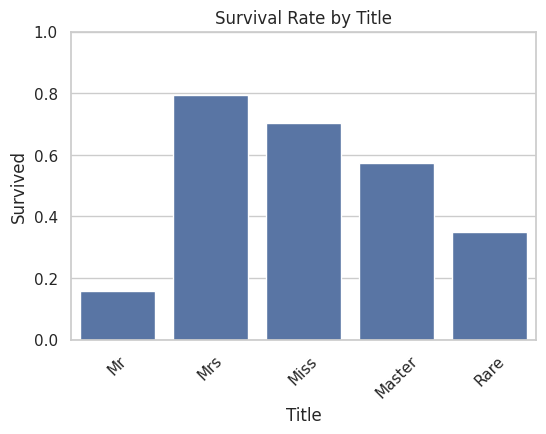

/tmp/ipython-input-3039648631.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="Survived", data=train_view, ci=None)


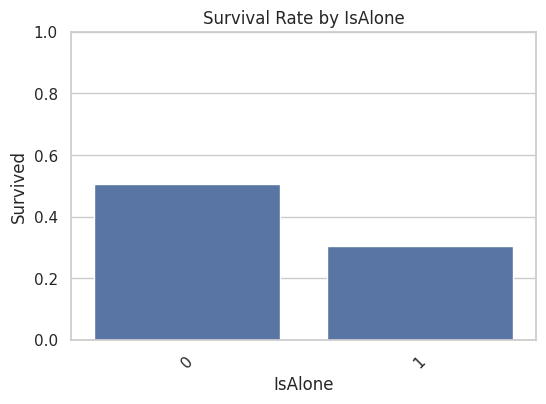

/tmp/ipython-input-3039648631.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="Survived", data=train_view, ci=None)


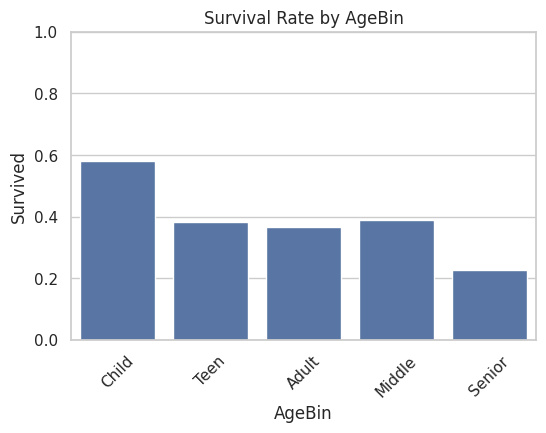

/tmp/ipython-input-3039648631.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y="Survived", data=train_view, ci=None)


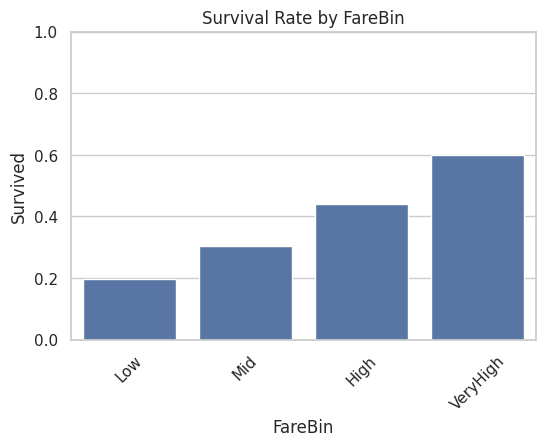

In [47]:
# 5. Re-run automated categorical survival plots (now with engineered cats)
# create a fresh train view to plot against Survived
train_view = full.loc[full["Survived"].notnull()].copy()

auto_cat_cols = ["Pclass","Sex","Embarked","Title","IsAlone","AgeBin","FareBin"]
for col in auto_cat_cols:
    plt.figure(figsize=(6,4))
    sns.barplot(x=col, y="Survived", data=train_view, ci=None)
    plt.title(f"Survival Rate by {col}")
    plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.show()

In [48]:
# 6. Prepare data for modeling (pipelines)

num_feats = ["Age","Fare","FamilySize","SibSp","Parch"]
cat_feats = ["Pclass","Sex","Embarked","Title","IsAlone","AgeBin","FareBin"]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([("num", num_pipe, num_feats), ("cat", cat_pipe, cat_feats)])

train_df = full.loc[full["Survived"].notnull()]
test_df = full.loc[full["Survived"].isnull()]

X = train_df[num_feats + cat_feats]
y = train_df["Survived"].astype(int)
X_test_final = test_df[num_feats + cat_feats]


In [49]:
# 7. Models + hyperparameter tuning (includes XGBoost & LightGBM)

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [50]:
# install boosters
!pip install -q xgboost lightgbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), {"C":[0.1,1,10]}),
    "SVC": (SVC(), {"C":[0.1,1,10], "kernel":["rbf","linear"], "gamma":["scale","auto"]}),
    "KNN": (KNeighborsClassifier(), {"n_neighbors":[3,5,7], "weights":["uniform","distance"]}),
    "RandomForest": (RandomForestClassifier(random_state=42), {"n_estimators":[100,200], "max_depth":[None,5,10]}),
    "GradientBoosting": (GradientBoostingClassifier(random_state=42), {"n_estimators":[100,200], "learning_rate":[0.01,0.1]}),
    "XGBoost": (XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42), {"n_estimators":[100,200], "learning_rate":[0.01,0.1]}),
    "LightGBM": (LGBMClassifier(random_state=42), {"n_estimators":[100,200], "learning_rate":[0.01,0.1]})
}

results = []
for name, (model, params) in models.items():
    pipe = Pipeline([("preproc", preprocessor), ("clf", model)])
    param_grid = {f"clf__{k}": v for k, v in params.items()}
    grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
    grid.fit(X, y)
    print(f"{name} -> Best CV accuracy: {grid.best_score_:.4f} | best params: {grid.best_params_}")
    results.append((name, grid.best_score_, grid.best_estimator_))




LogisticRegression -> Best CV accuracy: 0.8215 | best params: {'clf__C': 1}
SVC -> Best CV accuracy: 0.8361 | best params: {'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
KNN -> Best CV accuracy: 0.8294 | best params: {'clf__n_neighbors': 5, 'clf__weights': 'uniform'}
RandomForest -> Best CV accuracy: 0.8395 | best params: {'clf__max_depth': 10, 'clf__n_estimators': 200}
GradientBoosting -> Best CV accuracy: 0.8417 | best params: {'clf__learning_rate': 0.1, 'clf__n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:15:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost -> Best CV accuracy: 0.8440 | best params: {'clf__learning_rate': 0.1, 'clf__n_estimators': 100}
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
LightGBM -> Best CV accuracy: 0.8350 | best params: {'clf__learning_rate': 0.01, 'clf__n_estimators': 200}


In [51]:
# 8. Select best model, fit on full train, evaluate on holdout split
best_name, best_score, best_estimator = max(results, key=lambda r: r[1])
print(f"\nSelected model: {best_name} (CV acc = {best_score:.4f})")



Selected model: XGBoost (CV acc = 0.8440)


**Model Training & Tuning**

Tried multiple classification algorithms: Logistic Regression, SVC, KNN, Random Forest, Gradient Boosting, XGBoost, and LightGBM.

Used GridSearchCV with StratifiedKFold for hyperparameter tuning.

Compared models based on cross-validation accuracy.

**Best performing model: XGBoost with CV accuracy 0.8440.**

Other strong contenders: GradientBoosting (0.8417) and RandomForest (0.8395).

The difference between top models was small, showing the dataset is well-structured but limited in complexity.

In [52]:
# Retrain on full train and predict test
best_estimator.fit(X, y)
test_preds = best_estimator.predict(X_test_final)

submission = pd.DataFrame({"PassengerId": test_ids, "Survived": test_preds.astype(int)})
submission.to_csv("submission.csv", index=False)
files.download("submission.csv")

print("\nDone — submission.csv downloaded. If you want, I can now add feature-importance plots or SHAP explanation for the final model.")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:15:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Done — submission.csv downloaded. If you want, I can now add feature-importance plots or SHAP explanation for the final model.
